<a href="https://colab.research.google.com/github/galbraun/knesset_social_dynamics/blob/master/ERGM_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful links:
* Start with [introduction to ergm](https://cran.r-project.org/web/packages/ergm/vignettes/ergm.pdf)
* Example: [Lessons on exponential random graph modeling from Grey’s Anatomy hook-ups](http://badhessian.org/2012/09/lessons-on-exponential-random-graph-modeling-from-greys-anatomy-hook-ups/)


[introduction to ergm](https://cran.r-project.org/web/packages/ergm/vignettes/ergm.pdf)
1. begin with the simplest possible model, the Bernoulli (aka Erdős–Rényi) model, which contains only an edge term. Example in **pages 4-5**
2. Next, examine the influence of triangles on edges, which have positive effect. Moreover, we examine
the influence of a feature (wealth) on the edges, using nodecov('wealth'). We can see three * * * near to edges, with positive coefficient. Therefore there is a significant positive wealth effect on the probability of a tie **- pages 5-8**
3. Next example with big graphs irrelvant for us.
4. Example of simulate: pages 11-13



# Todo
1. חברי כנסת לא מאותה מפלגה
2. אנשים חיצוניים, נתייחס בהמשך העבודה
3. לרשום בדו"ח, שעבדנו מתודולוגית


# Todo gal: add the creation on the network. Eventually, write the data into two files, for each network

In [158]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [159]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [161]:
%%capture
%%R
install.packages('network')
install.packages('ergm')
install.packages('sna')
install.packages('coda')
library(network)
library(ergm)
library(sna)
library(coda)

set.seed(1)

In [162]:
%%R
build_network <- function(adj_mat_path, features_path) {
    # read the adjacency matrix
    ga.mat <- as.matrix(read.table(adj_mat_path, sep=",", header=T, row.names=1, quote="\""))

    # read the network attributes
    ga.atts <- read.table(features_path, sep=",", header=T, quote="\"", stringsAsFactors=F, strip.white=T, as.is=T)

    # create a network object using the adjacency matrix and its corresponding attributes
    ga.net <- network(ga.mat, vertex.attr=ga.atts, vertex.attrnames=colnames(ga.atts), directed=T, hyper=F, loops=F, multiple=F, bipartite=F)

    return(ga.net)
}

# Read data from drive

In [163]:
%%R
# adjacency matrices paths
huka_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/huka_adj.csv'
hutz_bitahon_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/hutz_bitahon_adj.csv'
knesset_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/knesset_adj.csv'
ksafim_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/ksafim_adj.csv'

# feature matrices paths
huka_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv'
hutz_bitahon_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv'
knesset_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv'
ksafim_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv'

In [164]:
# build networks
%%R
huka_net = build_network(huka_adj_path, huka_feat_path)
hutz_bitahon_net = build_network(hutz_bitahon_adj_path, hutz_bitahon_feat_path)
knesset_net = build_network(knesset_adj_path, knesset_feat_path)
ksafim_net = build_network(ksafim_adj_path, ksafim_feat_path)

In [166]:
def draw_graph_from_adj(adj_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  n_sizes = [50*d+10 for d in dict(G.degree).values()]
  labels = {node:node[::-1] for node in G.nodes()}
  nx.draw(G, node_size=n_sizes, ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

Text(0.5, 1.0, 'םיפסכה תדעו')

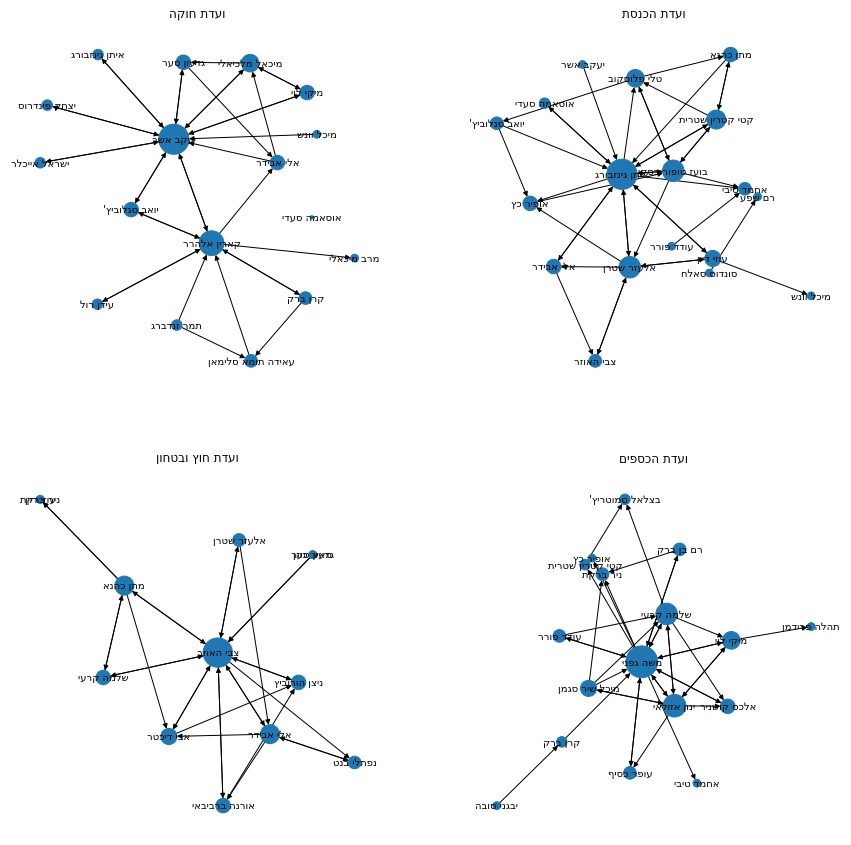

In [167]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_graph_from_adj('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/huka_adj.csv', ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/hutz_bitahon_adj.csv', ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/knesset_adj.csv', ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/ksafim_adj.csv', ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

### We begin with the simplest possible model, the Erdős–Rényi model, which contains only an edge term. Recall that a directed graph with $N$ vertices, has  maximum  $N\cdot (N-1)$ directed edges.

In [168]:
%%R
print(huka_net)

 Network attributes:
  vertices = 17 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 35 
    missing edges= 0 
    non-missing edges= 35 

 Vertex attribute names: 
    age faction FirstName FullName gender in_col in_gov KM_id LastName pazam_knesset vertex.names wing 

No edge attributes


In [169]:
%%R
huka_net.01 <- ergm(huka_net ~ edges) # fit model
summary(huka_net.01)

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 




Summary of model fit

Formula:   huka_net ~ edges

Iterations:  5 out of 20 

Monte Carlo MLE Results:
      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges  -1.9127     0.1811      0  -10.56   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 377.1  on 272  degrees of freedom
 Residual Deviance: 208.8  on 271  degrees of freedom
 
AIC: 210.8    BIC: 214.4    (Smaller is better.) 


#### Meaning that, the log-odds of any edge occurring is -1.9127. The corresponding probability is $\frac{e^{-1.9127}}{1+e^{-1.9127}} = 0.128678$, which is what we expect, since there are $\frac{35}{17 \cdot 16}$ edges.

#### Now, we test whether edge probabilities are a function of pazam_knesset:

In [170]:
def draw_pazam_dist(adj_path, ax=None):
  df = pd.read_csv(adj_path)
  df['FullName'] = df['FullName'].apply(lambda x: x[::-1])
  df.sort_values('pazam_knesset', inplace=True)
  df.plot(kind='bar', rot=80, x='FullName', y='pazam_knesset', ax=ax)

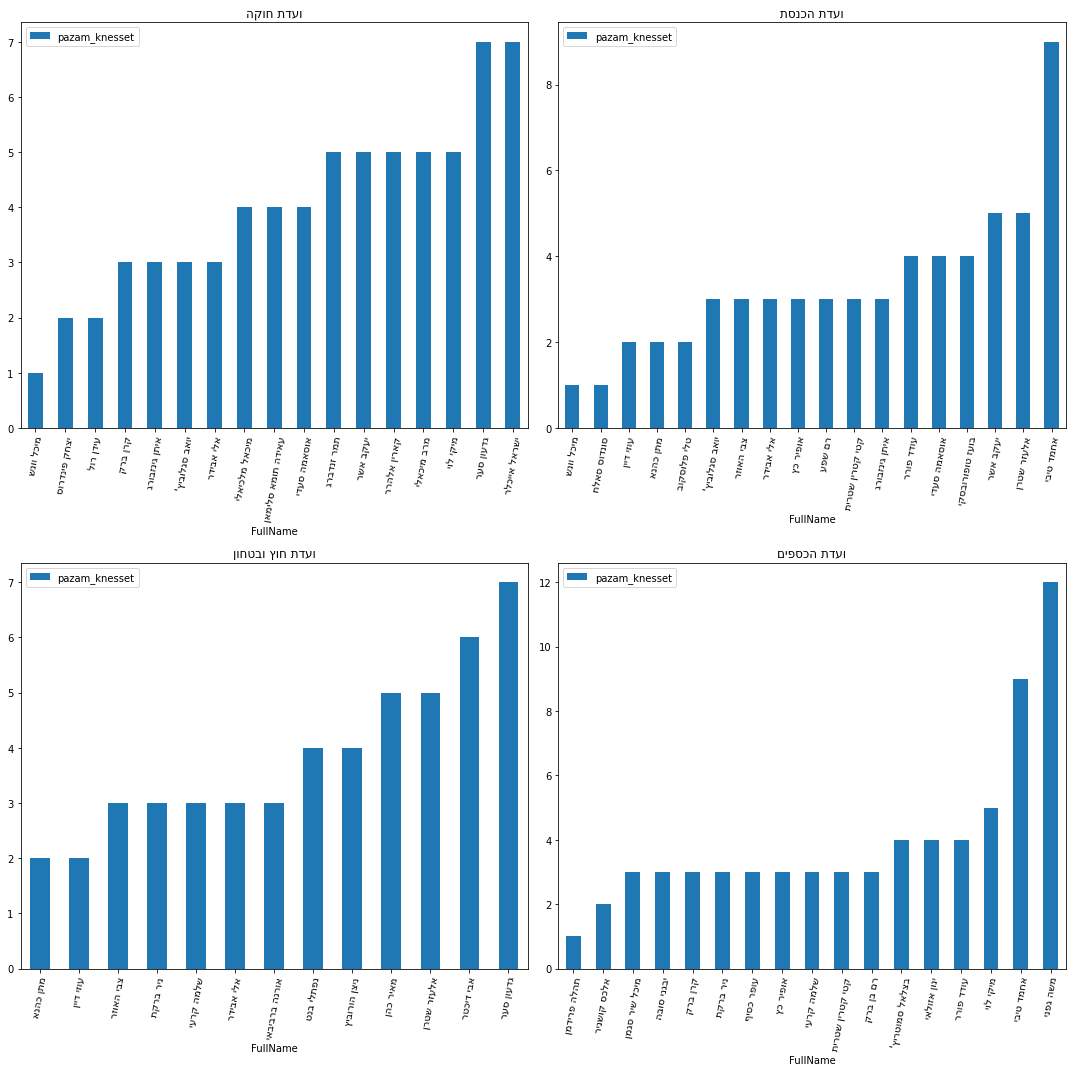

In [171]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_pazam_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv', ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_pazam_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv', ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_pazam_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv', ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_pazam_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv', ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()


In [172]:
def draw_graph_from_adj_by_pazam(adj_path, feat_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  feat_matrix = pd.read_csv(feat_path)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  n_sizes = [100*feat_matrix[feat_matrix['FullName'] == node]['pazam_knesset'].values[0] for node in G.nodes()]
  labels = {node:node[::-1] for node in G.nodes()}
  nx.draw(G, node_size=n_sizes, ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

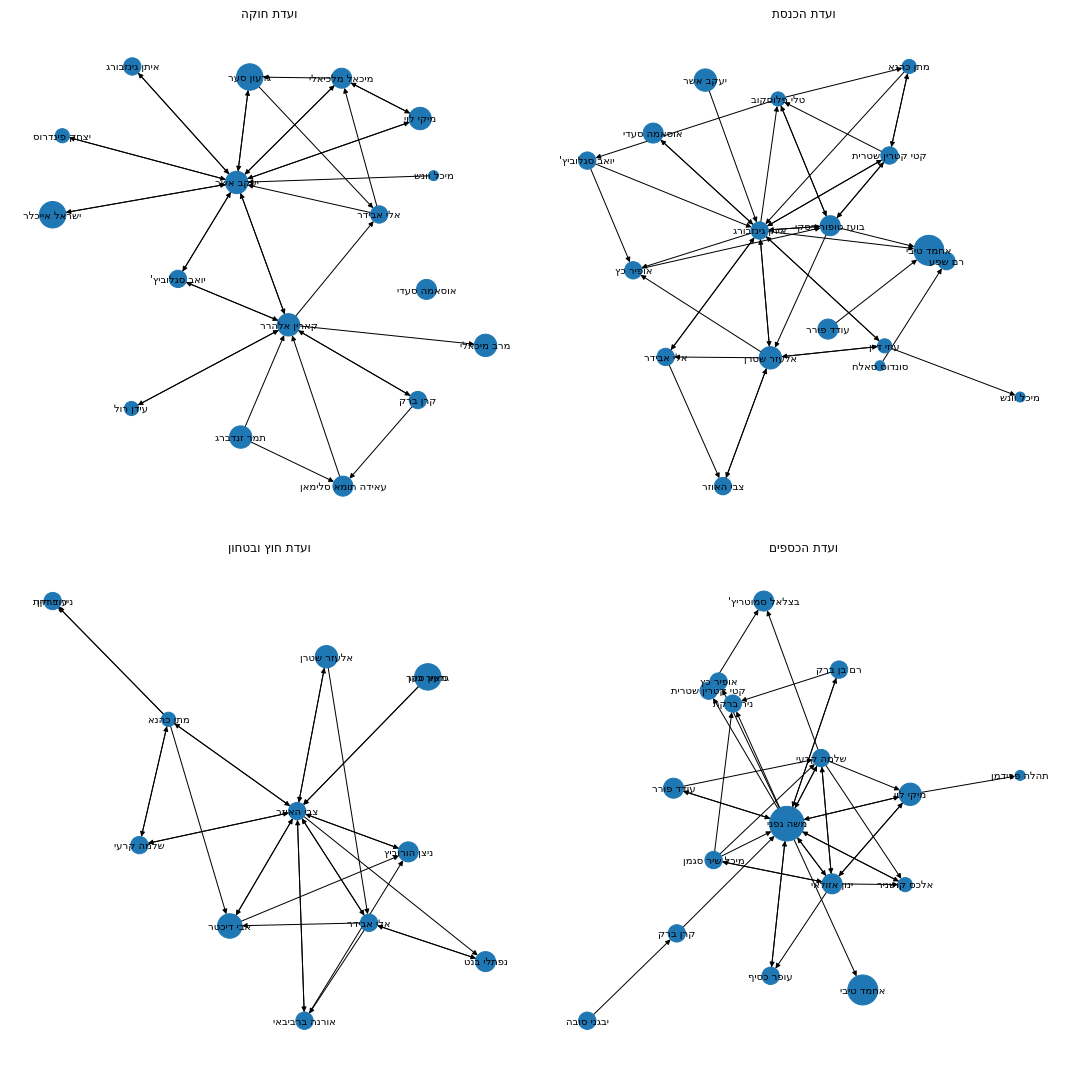

In [173]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_graph_from_adj_by_pazam('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/huka_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv', ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj_by_pazam('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/hutz_bitahon_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv', ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj_by_pazam('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/knesset_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv', ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj_by_pazam('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/ksafim_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv', ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()


In [174]:
%%capture
%%R
huka_net.pazam <- ergm(huka_net ~ edges + nodecov("pazam_knesset"))
hutz_bitahon_net.pazam <- ergm(hutz_bitahon_net ~ edges + nodecov("pazam_knesset"))
knesset_net.pazam <- ergm(knesset_net ~ edges + nodecov("pazam_knesset"))
ksafim_net.pazam <- ergm(ksafim_net ~ edges + nodecov("pazam_knesset"))

In [175]:
%%R
print("huka_net")
print(huka_net.pazam)
print("hutz_bitahon_net")
print(hutz_bitahon_net.pazam)
print("knesset_net")
print(knesset_net.pazam)
print("ksafim_net")
print(ksafim_net.pazam)

# print(summary(huka_net.pazam))
# print(summary(hutz_bitahon_net.pazam))
# print(summary(knesset_net.pazam))
# print(summary(ksafim_net.pazam))

[1] "huka_net"

MLE Coefficients:
                edges  nodecov.pazam_knesset  
              -3.6872                 0.2118  
[1] "hutz_bitahon_net"

MLE Coefficients:
                edges  nodecov.pazam_knesset  
               0.5942                -0.2813  
[1] "knesset_net"

MLE Coefficients:
                edges  nodecov.pazam_knesset  
             -1.98255                0.01736  
[1] "ksafim_net"

MLE Coefficients:
                edges  nodecov.pazam_knesset  
              -4.2903                 0.2689  


# ==== Todo Conclusions 1 ====



#### Next, we examine if two Knesset members within the same faction tend to   interrupt each other:

In [176]:
def draw_faction_dist(adj_path, ax=None):
  df = pd.read_csv(adj_path)
  df['faction'] = df['faction'].apply(lambda x: x[::-1])
  df['faction'].value_counts().plot(kind='bar', ax=ax, rot=60)

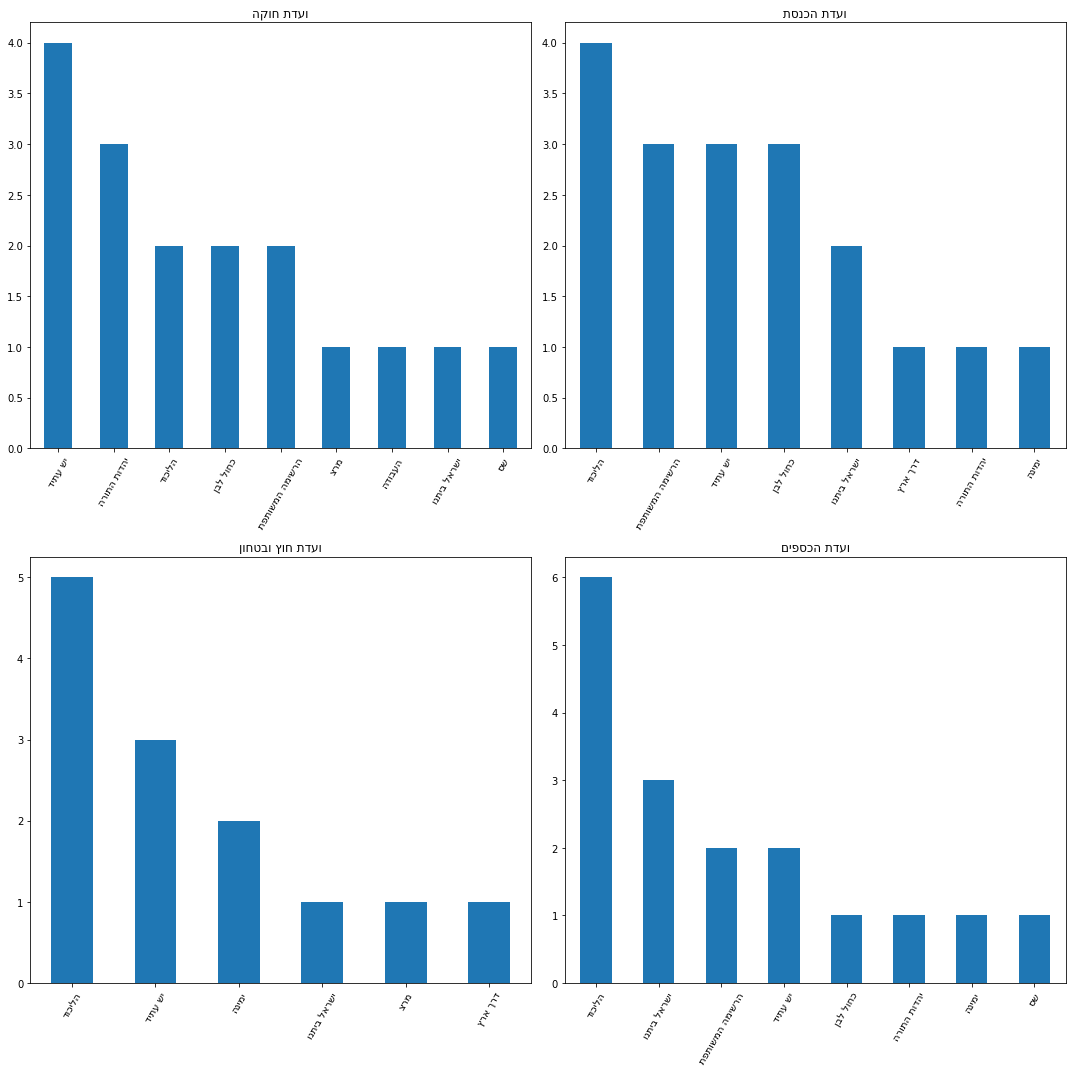

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_faction_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv', ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_faction_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv', ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_faction_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv', ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_faction_dist('/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv', ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()


In [188]:
factions = pd.read_csv('/content/drive/Shared drives/NLPSD/data/knesset_members_metadata.csv')['faction'].unique()
fact_to_color = dict(zip(factions, cm.tab20.colors))

In [208]:
def draw_graph_from_adj_by_faction(adj_path, feat_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  feat_matrix = pd.read_csv(feat_path)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  labels = {node:node[::-1] for node in G.nodes()}
  n_colors = [fact_to_color[feat_matrix[feat_matrix['FullName'] == node]['faction'].values[0]] for node in G.nodes()]
  nx.draw(G, node_color=n_colors , ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

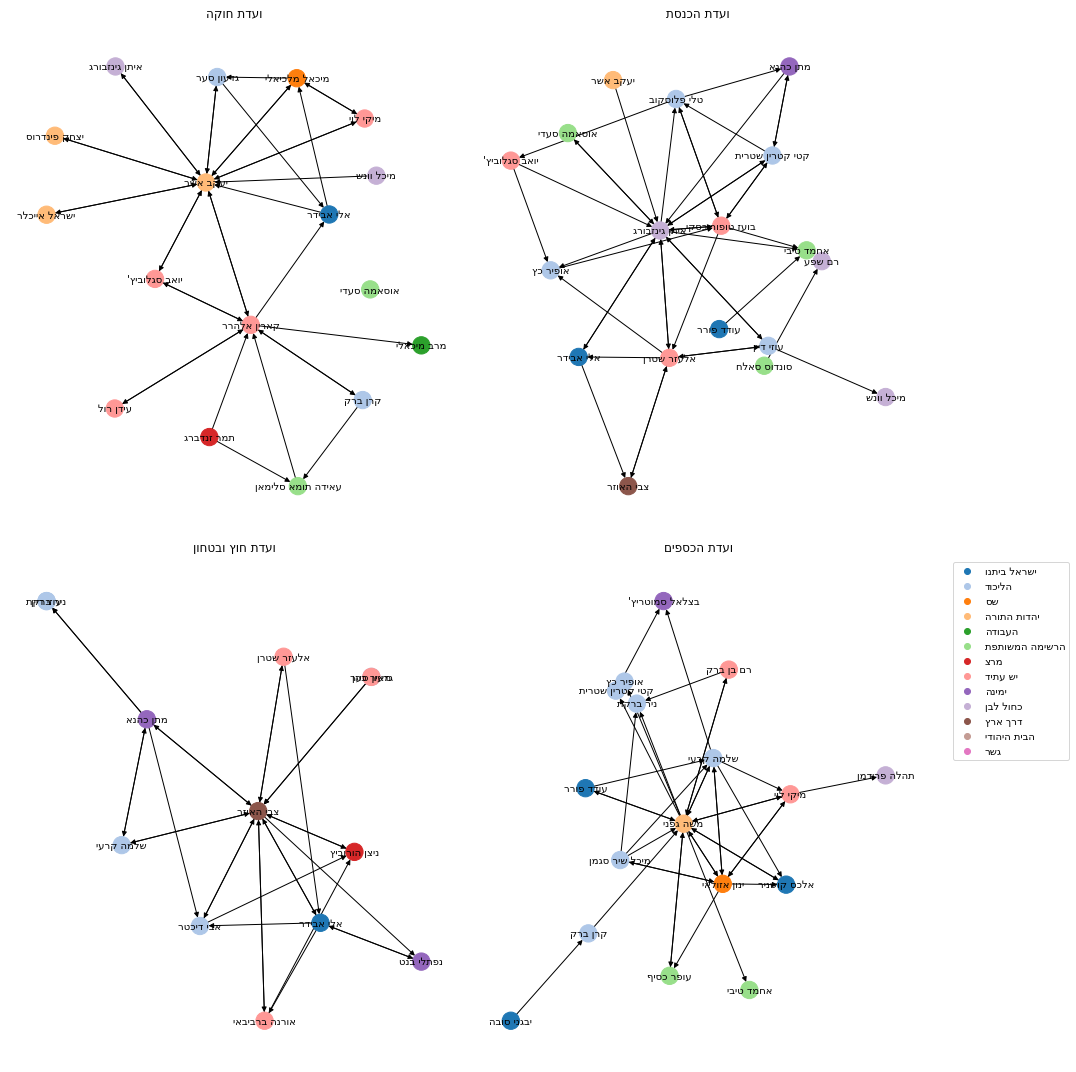

In [220]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plt.legend(markers, fact_to_color_rev.keys(), numpoints=1, bbox_to_anchor=(1.05, 1.0), loc='upper left')

draw_graph_from_adj_by_faction('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/huka_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv', ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj_by_faction('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/hutz_bitahon_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv', ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj_by_faction('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/knesset_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv', ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj_by_faction('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/ksafim_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv', ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()

fact_to_color_rev = {fact[::-1]:fact_to_color[fact] for fact in fact_to_color}
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in fact_to_color_rev.values()]


In [179]:
%%capture
%%R
huka_net.faction <- ergm(huka_net ~ edges + nodematch("faction"))
hutz_bitahon_net.faction <- ergm(hutz_bitahon_net ~ edges + nodematch("faction"))
knesset_net.faction <- ergm(knesset_net ~ edges + nodematch("faction"))
ksafim_net.faction <- ergm(ksafim_net ~ edges + nodematch("faction"))

In [ ]:
%%R
print(huka_net.faction)
print(hutz_bitahon_net.faction)
print(knesset_net.faction)
print(ksafim_net.faction)

# print(summary(huka_net.faction))
# print(summary(hutz_bitahon_net.faction))
# print(summary(knesset_net.faction))
# print(summary(ksafim_net.faction))


MLE Coefficients:
            edges  nodematch.faction  
           -2.102              1.409  

MLE Coefficients:
            edges  nodematch.faction  
           -1.228               -Inf  

MLE Coefficients:
            edges  nodematch.faction  
           -1.796             -0.912  

MLE Coefficients:
            edges  nodematch.faction  
           -1.695             -1.250  


#### Let's look more in depth:

In [ ]:
%%R
huka_net.faction2 <- ergm(huka_net ~ edges + nodematch('faction', diff=T))
summary(huka_net.faction2)

R[write to console]: Observed statistic(s) nodematch.faction.הליכוד, nodematch.faction.העבודה, nodematch.faction.הרשימה המשותפת, nodematch.faction.ישראל ביתנו, nodematch.faction.כחול לבן, nodematch.faction.מרצ, and nodematch.faction.שס are at their smallest attainable values. Their coefficients will be fixed at -Inf.

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 




Summary of model fit

Formula:   huka_net ~ edges + nodematch("faction", diff = T)

Iterations:  5 out of 20 

Monte Carlo MLE Results:
                                 Estimate Std. Error MCMC % z value Pr(>|z|)
edges                             -2.1023     0.2039      0 -10.313  < 1e-04
nodematch.faction.הליכוד             -Inf     0.0000      0    -Inf  < 1e-04
nodematch.faction.העבודה             -Inf     0.0000      0    -Inf  < 1e-04
nodematch.faction.הרשימה המשותפת     -Inf     0.0000      0    -Inf  < 1e-04
nodematch.faction.יהדות התורה      2.7955     0.8897      0   3.142  0.00168
nodematch.faction.יש עתיד          1.4092     0.6454      0   2.183  0.02901
nodematch.faction.ישראל ביתנו        -Inf     0.0000      0    -Inf  < 1e-04
nodematch.faction.כחול לבן           -Inf     0.0000      0    -Inf  < 1e-04
nodematch.faction.מרצ                -Inf     0.0000      0    -Inf  < 1e-04
nodematch.faction.שס                 -Inf     0.0000      0    -Inf  < 1e-04
                

In [ ]:
# ==== Todo Conclusions 2 ====

In [ ]:
%%R
data(florentine)
flomodel.03 <- ergm(flomarriage~edges+nodecov('wealth'))

flomodel.03.sim <- simulate(flomodel.03,nsim=10)

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 



In [ ]:
%%R
summary(flomodel.03.sim)

Number of Networks: 10 
Model: flomarriage ~ edges + nodecov("wealth") 
Reference: ~Bernoulli 
Constraints: TNT NULL 16   , 1    , 15   , 2    , 14   , 3    , 13   , 4    , 12   , 5    , 11   , 6    , 10   , 7    , 9    , 8    , 8    , 9    , 7    , 10   , 6    , 11   , 5    , 12   , 4    , 13   , 3    , 14   , 2    , 15   , 1    , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, FALSE, 1    , FALSE, FALSE Bernoulli, MPLE     , CD       , zeros     ergm 
Parameters:
         edges nodecov.wealth 
   -2.59492903     0.01054591 

Stored network statistics:
      edges nodecov.wealth
 [1,]    19           1940
 [2,]    18           1721
 [3,]    21           2248
 [4,]    13           1626
 [5,]    24           2503
 [6,]    18           2251
 [7,]    22           1814
 [8,]    14           1561
 [9,]    18           1785
[

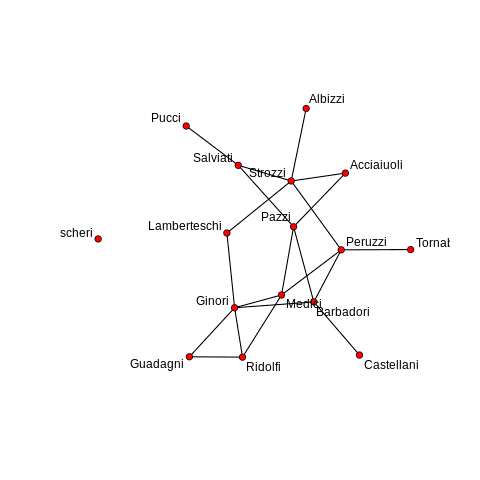

In [ ]:
%%R
plot(flomodel.03.sim[[3]], label= flomodel.03.sim[[3]] %v% "vertex.names")